In [ ]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing
import os

if "../" not in sys.path:
  sys.path.append("../") 

from lib import plotting
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

In [ ]:
env = gym.envs.make("MountainCar-v0")
env = wrappers.Monitor(env, '/tmp/mtcar-experiment-1', force=True)

In [ ]:
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Used to converte a state to a featurizes represenation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])

featurizer.fit(scaler.transform(observation_examples))
scaled = scaler.transform(observation_examples)

In [ ]:
class Estimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self):
        # We create a separate model for each action in the environment's
        # action space. Alternatively we could somehow encode the action
        # into the features, but this way it's easier to code up.
        self.models = []
        for _ in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant")
            # We need to call partial_fit once to initialize the model
            # or we get a NotFittedError when trying to make a prediction
            # This is quite hacky.
            model.partial_fit([self.featurize_state(env.reset())], [0])
            self.models.append(model)
    
    def featurize_state(self, state):
        """
        Returns the featurized representation for a state.
        """
        scaled = scaler.transform([state])
        featurized = featurizer.transform(scaled)
        return featurized[0]
    
    def predict(self, s, a=None):
        """
        Makes value function predictions.
        
        Args:
            s: state to make a prediction for
            a: (Optional) action to make a prediction for
            
        Returns
            If an action a is given this returns a single number as the prediction.
            If no action is given this returns a vector or predictions for all actions
            in the environment where pred[i] is the prediction for action i.
            
        """
        # TODO: Implement this!
        X = [self.featurize_state(s)]
        if a:    
            pred = self.models[a].predict(X)[0]
        else:
            preds = np.zeros(env.action_space.n)
            for i in range(env.action_space.n):                
                preds[i] = self.models[i].predict(X)[0]                    
        return pred if a else preds
    
    def update(self, s, a, y):
        """
        Updates the estimator parameters for a given state and action towards
        the target y.
        """
        
        # TODO: Implement this!
        X = [self.featurize_state(s)]
        self.models[a].partial_fit(X, [y])
        return None

In [ ]:
def make_epsilon_greedy_policy(estimator, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    
    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [ ]:
def q_learning(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):
    """
    Q-Learning algorithm for fff-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Lambda time discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    for i_episode in range(num_episodes):
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(
            estimator, epsilon * epsilon_decay**i_episode, env.action_space.n)
        
        sys.stdout.flush()

        # TODO: Implement this!
        # decay epsilon
        s = env.reset()
        rAll = 0
        # TODO: accomodate SARSA
        for t in itertools.count():            
            probs = policy(s)
            a = np.random.choice(np.arange(len(probs)), p=probs)

            next_s, r, done, _ = env.step(a)

            next_q_values = estimator.predict(next_s)                               
            td_target = r + discount_factor * np.max(next_q_values)                
            
            estimator.update(s, a, td_target)
                        
            if done:
                break
            
            rAll += r
            s = next_s

        stats.episode_rewards[i_episode] = rAll
        stats.episode_lengths[i_episode] = t
    return stats

In [ ]:
estimator = Estimator()

In [ ]:
# Note: For the Mountain Car we don't actually need an epsilon > 0.0
# because our initial estimate for all states is too "optimistic" which leads
# to the exploration of all states.
stats = q_learning(env, estimator, 100, epsilon=0.0)
env.close()
OPENAI_API_KEY = os.environ['OPENAI_API_KEY']
gym.upload('/tmp/mtcar-experiment-1', api_key=OPENAI_API_KEY)

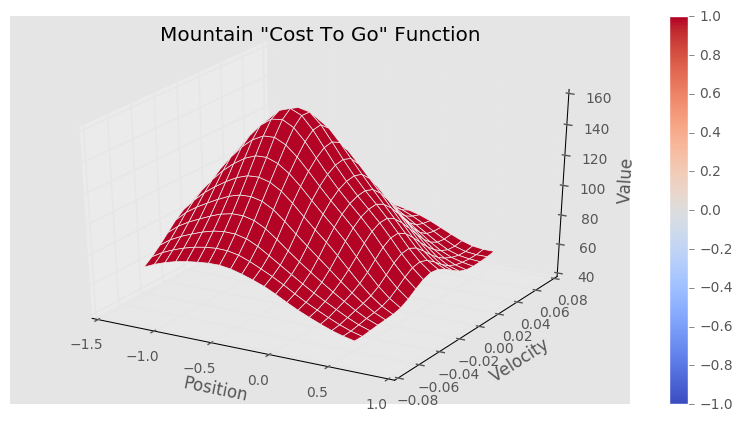

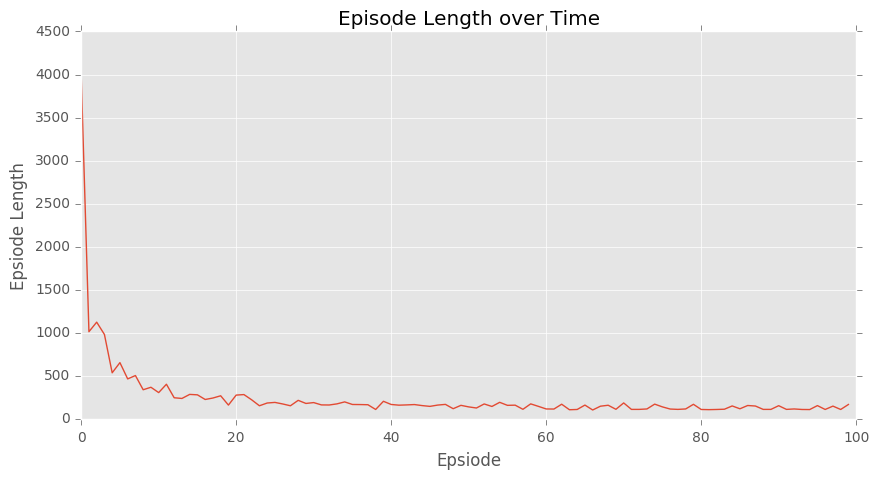

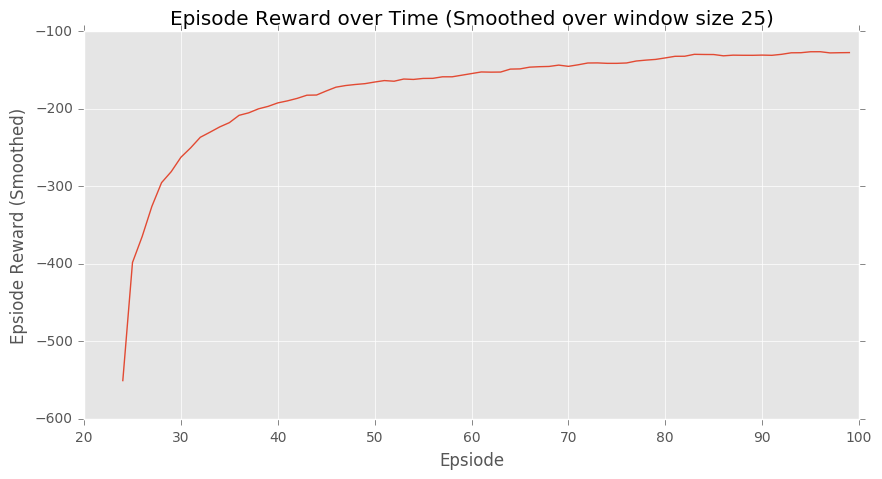

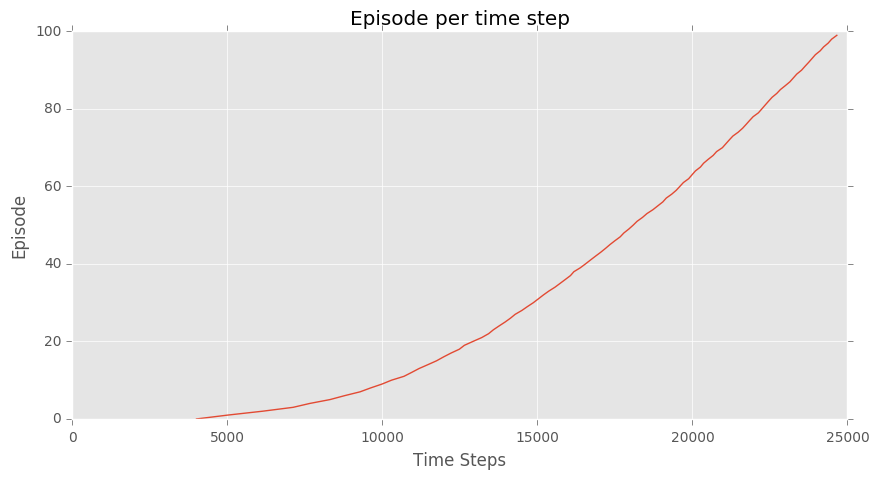

(<matplotlib.figure.Figure at 0x115bcdb38>,
 <matplotlib.figure.Figure at 0x11624c898>)

In [10]:
plotting.plot_cost_to_go_mountain_car(env, estimator)
plotting.plot_episode_stats(stats, smoothing_window=25)

In [ ]:
import time

# junk_estimator = Estimator()

state = env.reset()
for t in itertools.count():    
    q_values = estimator.predict(state)
    chosen_action = np.argmax(q_values)
    next_s, r, done, _ = env.step(chosen_action)
    plt.figure()
    plt.imshow(env.render(mode='rgb_array'))
    
    state = next_s
    
    if done:
        print("finished at the time step of {}".format(t))
        env.render(close=True)        
        break    

finished at the time step of 109
